<img align=right src="https://github.com/INMAS-Math/Workshop-V-02/blob/main/images/inmas.png?raw=1" width=130x />

# Notebook 03b - Multiple Linear Regression - Supplement

Material covered in this notebook:

This notebook follows along the notes [here](notes/3_MultipleLinearRegression.pdf)


### Prerequisite
Notebook 03a

------------------------------------

In [3]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sbn
import scipy.stats as stats
import pandas as pd

# Feature Selection for Regression

We introduced multiple regression, which involved estimating the coefficients of a linear relationship between a dependent/response variable $Y$ and independent/predictor/feature variables $X_1,\dots,X_k$:

$$Y=\beta_0 + \beta_1X_1 +\cdots + \beta_kX_k$$

How do we know that we have put the right covariates into the model. How can we tell if our model is "good" or even "best"?

Let's revisit the course evaluation dataset and see if we can do better than our simple linear regression model.

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/akmand/datasets/master/openintro/evals.csv")
display(data)

data.columns

score          rank     ethnicity  gender     language  age  \
0      4.7  tenure track      minority  female      english   36   
1      4.1  tenure track      minority  female      english   36   
2      3.9  tenure track      minority  female      english   36   
3      4.8  tenure track      minority  female      english   36   
4      4.6       tenured  not minority    male      english   59   
..     ...           ...           ...     ...          ...  ...   
458    4.5  tenure track  not minority    male      english   32   
459    3.5  tenure track      minority  female  non-english   42   
460    4.4  tenure track      minority  female  non-english   42   
461    4.4  tenure track      minority  female  non-english   42   
462    4.1  tenure track      minority  female  non-english   42   

     cls_perc_eval  cls_did_eval  cls_students cls_level  ...   cls_credits  \
0         55.81395            24            43     upper  ...  multi credit   
1         68.80000            86           125     upper  ...  multi credit   
2         60.80000            76           125     upper  ...  multi credit   
3         62.60163            77           123     upper  ...  multi credit   
4         85.00000            17            20     upper  ...  multi credit   
..             ...           ...           ...       ...  ...           ...   
458       60.46511            52            86     upper  ...  multi credit   
459       57.14286            48            84     upper  ...  multi credit   
460       77.61194            52            67     upper  ...  multi credit   
461       81.81818            54            66     upper  ...  multi credit   
462       80.00000            28            35     lower  ...    one credit   

    bty_f1lower  bty_f1upper  bty_f2upper  bty_m1lower  bty_m1upper  \
0             5            7            6            2            4   
1             5            7            6            2            4   
2             5            7            6            2            4   
3             5            7            6            2            4   
4             4            4            2            2            3   
..          ...          ...          ...          ...          ...   
458           6            6            9            7            8   
459           3            8            7            4            6   
460           3            8            7            4            6   
461           3            8            7            4            6   
462           3            8            7            4            6   

     bty_m2upper  bty_avg  pic_outfit pic_color  
0              6    5.000  not formal     color  
1              6    5.000  not formal     color  
2              6    5.000  not formal     color  
3              6    5.000  not formal     color  
4              3    3.000  not formal     color  
..           ...      ...         ...       ...  
458            5    6.833  not formal     color  
459            4    5.333  not formal     color  
460            4    5.333  not formal     color  
461            4    5.333  not formal     color  
462            4    5.333  not formal     color  

[463 rows x 21 columns]

Index(['score', 'rank', 'ethnicity', 'gender', 'language', 'age',
       'cls_perc_eval', 'cls_did_eval', 'cls_students', 'cls_level',
       'cls_profs', 'cls_credits', 'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
       'bty_m1lower', 'bty_m1upper', 'bty_m2upper', 'bty_avg', 'pic_outfit',
       'pic_color'],
      dtype='object')

In [5]:
linear_model_formulation = smf.ols("score ~ bty_avg", data = data)

lm_results = linear_model_formulation.fit()
lm_results.params

Intercept    3.880338
bty_avg      0.066637
dtype: float64

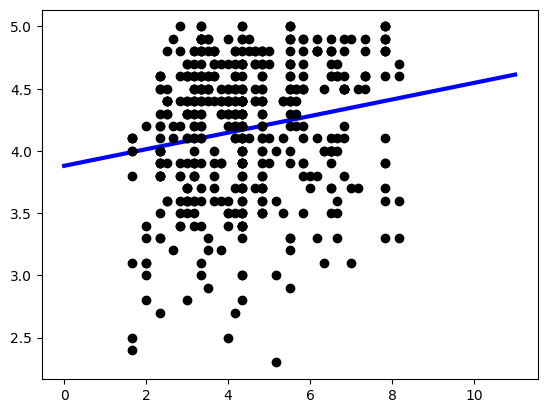

In [6]:
beta_ests = np.flip(np.array(lm_results.params))
x_vals = np.linspace(0,11,1000)
y_vals = [np.polyval(beta_ests, i) for i in x_vals]

plt.plot(x_vals, y_vals, color= 'blue', linewidth=3, zorder = 2)
plt.scatter(data.bty_avg, data.score, color = 'black', zorder = 2)

In [7]:
lm_summary = lm_results.summary()
print(lm_summary)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     16.73
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           5.08e-05
Time:                        20:27:22   Log-Likelihood:                -366.22
No. Observations:                 463   AIC:                             736.4
Df Residuals:                     461   BIC:                             744.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8803      0.076     50.961      0.0

In [8]:
#R^2 adjusted for the linear model
lm_results.rsquared_adj

0.03292903378612022

In [9]:
lm_results.aic

736.44490898058

In [10]:
lm_results.bic

744.7203630887524

We are only explaining about 3% of the variation in course evaluation scores. What else can we add to the model to help us without the model getting too unwieldy?

## Model Selection

Clearly a balance must be struck between model's complexity and  its capacity to effectively predict new data. The methods by which we strike this balance in practice fall under the category of **model selection**. The model selection task is typically cast as an application of **Occam's razor**, which may be summarized as:

   "Entities should not be multiplied beyond necessity."
    
I.e., in the presence of (equally likely) competing explanations for a phenomenon, the simplest should be preferred.

In parametric settings, this is typically carried out by computing, for each model under consideration, an expression of the form

$$\text{log-likelihood} - \text{complexity penalty}$$

Commonly used model selection criteria which fall under this paradigm include the **Akaike information criterion** (AIC) and **Bayesian information criterion** (BIC) which penalize the log-likelihood penalty respectively with

$$p_{\text{AIC}}=k\\
p_{\text{BIC}} = \frac{k}{2}\log n$$

## Forward Selection of Features

Forward selection involves the following procedure:

   1. Start with an empty regression model (i.e., just an intercept, if appropriate).
   2. For each feature not yet included, fit the model associated by including only that feature among.
   3. Note either the significance of the new feature (in the `.summary()` call) or a desired model selection criterion.
   4. If there is at least one feature which is significant or improves the criterion, keep the feature which is most significant or most improves the criterion and return to step 2.
   5. If no additional feature is significant or improves the criterion, return the model without any new features.

We will first use the $\text{adjusted-}R^2$ as our criterion since there's so few data. The adjusted R^2 accounts for the fact that we add complexity every time we add a new covariate. The regular R^2 will always increase when we add a new covariate. This is not necessarily true of the adjusted version.

To simplify we will only consider a subset of the covariates.

- rank
- ethnicity
- gender
- age
- cls_perc_eval
- bty_avg


In [11]:
results_rank_only = smf.ols("score ~ rank", data = data).fit()
results_ethnicity_only = smf.ols("score ~ ethnicity", data = data).fit()
results_gender_only = smf.ols("score ~ gender", data = data).fit()
results_age_only = smf.ols("score ~ age", data = data).fit()
results_cls_perc_eval_only = smf.ols("score ~ cls_perc_eval", data = data).fit()


print("Adj Rsquared for rank only is "+ str(results_rank_only.rsquared_adj))
print("Adj Rsquared for ethnicity only is "+ str(results_ethnicity_only.rsquared_adj))
print("Adj Rsquared for gender only is "+ str(results_gender_only.rsquared_adj))
print("Adj Rsquared for age only is "+ str(results_age_only.rsquared_adj))
print("Adj Rsquared for cls_perc_eval only is "+ str(results_cls_perc_eval_only.rsquared_adj))


Adj Rsquared for rank only is 0.007331676549560018
Adj Rsquared for ethnicity only is 0.0035925827913851904
Adj Rsquared for gender only is 0.014406319038144377
Adj Rsquared for age only is 0.00931149520785346
Adj Rsquared for cls_perc_eval only is 0.03219179847301612


It looks like using bty_score is the best first covariate. Now what can we add to it to improve the most?

In [12]:
results_bty_rank_only = smf.ols("score ~ rank + bty_avg", data = data).fit()
results_bty_ethnicity_only = smf.ols("score ~ ethnicity + bty_avg", data = data).fit()
results_bty_gender_only = smf.ols("score ~ gender + bty_avg", data = data).fit()
results_bty_age_only = smf.ols("score ~ age + bty_avg", data = data).fit()
results_bty_cls_perc_eval_only = smf.ols("score ~ cls_perc_eval + bty_avg", data = data).fit()


print("Adj Rsquared for bty_rank only is "+ str(results_bty_rank_only.rsquared_adj))
print("Adj Rsquared for bty_ethnicity only is "+ str(results_bty_ethnicity_only.rsquared_adj))
print("Adj Rsquared for bty_gender only is "+ str(results_bty_gender_only.rsquared_adj))
print("Adj Rsquared for bty_age only is "+ str(results_bty_age_only.rsquared_adj))
print("Adj Rsquared for bty_cls_perc_eval only is "+ str(results_bty_cls_perc_eval_only.rsquared_adj))

Adj Rsquared for bty_rank only is 0.04028747482602257
Adj Rsquared for bty_ethnicity only is 0.037850768149103375
Adj Rsquared for bty_gender only is 0.055032019860021264
Adj Rsquared for bty_age only is 0.033597442612292805
Adj Rsquared for bty_cls_perc_eval only is 0.056034910844585784


bty_avg and cls_perc_eval work best together. Now what do we add?

In [13]:
results_bty_cls_rank_only = smf.ols("score ~ rank + bty_avg + cls_perc_eval", data = data).fit()
results_bty_cls_ethnicity_only = smf.ols("score ~ ethnicity + bty_avg  + cls_perc_eval", data = data).fit()
results_bty_cls_gender_only = smf.ols("score ~ gender + bty_avg  + cls_perc_eval", data = data).fit()
results_bty_cls_age_only = smf.ols("score ~ age + bty_avg  + cls_perc_eval", data = data).fit()


print("Adj Rsquared for bty_cls_rank only is "+ str(results_bty_cls_rank_only.rsquared_adj))
print("Adj Rsquared for bty_cls_ethnicity only is "+ str(results_bty_cls_ethnicity_only.rsquared_adj))
print("Adj Rsquared for bty_cls_gender only is "+ str(results_bty_cls_gender_only.rsquared_adj))
print("Adj Rsquared for bty_cls_age only is "+ str(results_bty_cls_age_only.rsquared_adj))


Adj Rsquared for bty_cls_rank only is 0.061875790519964946
Adj Rsquared for bty_cls_ethnicity only is 0.06538860180790873
Adj Rsquared for bty_cls_gender only is 0.08197000196964344
Adj Rsquared for bty_cls_age only is 0.05577334737711426


Adding gender helps. Let's keep going.

In [14]:
results_bty_cls_gender_rank_only = smf.ols("score ~ rank + bty_avg + cls_perc_eval + gender", data = data).fit()
results_bty_cls_gender_ethnicity_only = smf.ols("score ~ ethnicity + bty_avg  + cls_perc_eval + gender", data = data).fit()
results_bty_cls_gender_age_only = smf.ols("score ~ age + bty_avg  + cls_perc_eval + gender", data = data).fit()


print("Adj Rsquared for bty_cls_gender_rank only is "+ str(results_bty_cls_gender_rank_only.rsquared_adj))
print("Adj Rsquared for bty_cls_gender_ethnicity only is "+ str(results_bty_cls_gender_ethnicity_only.rsquared_adj))
print("Adj Rsquared for bty_cls_gender_age only is "+ str(results_bty_cls_gender_age_only.rsquared_adj))

Adj Rsquared for bty_cls_gender_rank only is 0.08928593466798973
Adj Rsquared for bty_cls_gender_ethnicity only is 0.08813150427212946
Adj Rsquared for bty_cls_gender_age only is 0.0877207606117647


Rank helps but we start to see diminishing returns.

In [15]:
results_bty_cls_gender_rank_ethnicity_only = smf.ols("score ~ ethnicity + bty_avg  + cls_perc_eval + gender + rank", data = data).fit()
results_bty_cls_gender_rank_age_only = smf.ols("score ~ age + bty_avg  + cls_perc_eval + gender + rank", data = data).fit()


print("Adj Rsquared for bty_cls_gender_rank_ethnicity only is "+ str(results_bty_cls_gender_rank_ethnicity_only.rsquared_adj))
print("Adj Rsquared for bty_cls_gender_rank_age only is "+ str(results_bty_cls_gender_rank_age_only.rsquared_adj))

Adj Rsquared for bty_cls_gender_rank_ethnicity only is 0.09452214510156798
Adj Rsquared for bty_cls_gender_rank_age only is 0.10005867093478182


Age helps. Should we add the last variable?

In [16]:
results_bty_cls_gender_rank_age_ethnicity_only = smf.ols("score ~ ethnicity + bty_avg  + cls_perc_eval + gender + rank + age", data = data).fit()


print("Adj Rsquared for bty_cls_gender_rank_age_ethnicity only is "+ str(results_bty_cls_gender_rank_age_ethnicity_only.rsquared_adj))


Adj Rsquared for bty_cls_gender_rank_age_ethnicity only is 0.1048347370402738


This marginally helps. So the "full" model is not overkill based on this metric. Recall that this isn't really a full model because we only considered a subset of variables.

## Backward Selection of Features

If forward selection involves incrementally adding features to our model, then it naturally stands to reason that **backward selection** involves incrementally *removing* features. The procedure is as follows:

 1. Start with a full regression model.
 2. For each feature included in the model, fit the model which omits that feature.
 3. Note the model selection criterion in question.
 4. If there is at least one feature which, upon omission, improves the model selection criterion, omit the feature which results in the largest improvement, and return to step 2.
 5. Else, if omitting any feature does not improve the model selection criterion, return the current model.

In this case we are going to see if the variables are statistically significant in the presence of the other variables (at the 0.05 level).


In [17]:
full_mod = smf.ols("score ~ ethnicity + bty_avg  + cls_perc_eval + gender + rank + age", data = data).fit()
full_summary = full_mod.summary()
print(full_summary)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     8.729
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           4.44e-10
Time:                        20:27:22   Log-Likelihood:                -345.30
No. Observations:                 463   AIC:                             706.6
Df Residuals:                     455   BIC:                             739.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

The ethnicity binary categorical variable is not significant. We can remove it from the model.

In [18]:
smaller_mod = smf.ols("score ~ bty_avg  + cls_perc_eval + gender + rank + age", data = data).fit()
smaller_summary = smaller_mod.summary()
print(smaller_summary)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     9.561
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           6.51e-10
Time:                        20:27:22   Log-Likelihood:                -347.04
No. Observations:                 463   AIC:                             708.1
Df Residuals:                     456   BIC:                             737.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.9261 

Everything else is statistically significant. We can stop with this model.

## Your turn: Feature Selection for Iris Data

Perform forward feature selection on Fisher's *iris* dataset. Use `Petal_Length` as the response variable and the remaining four variables as the predictors. Note that `species` is a categorical factor.

Use either BIC or AIC as your criterion. Recall that in Python "lower BIC/AIC" equates to "better model." See [here](https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other) for some more details about the two metrics.

Then perform backward feature selection using a p-value cutoff of 0.06.

In [19]:
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Species']
iris = pd.read_csv(csv_url, names=col_names)

print(iris)

     Sepal_Length  Sepal_Width  Petal_Length  Petal_Width         Species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


## Check your understanding

Consider the two models you built. Which of them would you choose? Convince me using at least 2 pieces of evidence.  